In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
root_path = '/content/drive/MyDrive/Kvasir'

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.layers import *
from keras.models import *
from keras.preprocessing import image
import os
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import BatchNormalization
from keras.layers import Dense, Dropout, Flatten
from pathlib import Path
from keras.applications.vgg19 import VGG19, preprocess_input

In [5]:
#Defining paths
TRAIN_PATH = "/content/drive/MyDrive/Kvasir/Train"
TEST_PATH = "/content/drive/MyDrive/Kvasir/Test"

In [6]:
BATCH_SIZE = 64

train_datagen = image.ImageDataGenerator(preprocessing_function=preprocess_input, rotation_range=40, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, horizontal_flip=True, fill_mode="nearest", validation_split=0.1)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [7]:
train_generator = train_datagen.flow_from_directory(TRAIN_PATH,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               subset='training',
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True,
                                               seed=42)

validation_generator = train_datagen.flow_from_directory(TRAIN_PATH,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               subset='validation',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

test_generator = test_datagen.flow_from_directory(TEST_PATH,
                                             target_size=(224, 224),
                                             class_mode=None,
                                             batch_size=1,
                                             shuffle=False,
                                             seed=42)

Found 6480 images belonging to 8 classes.
Found 720 images belonging to 8 classes.
Found 800 images belonging to 8 classes.


In [8]:
from tensorflow.keras.layers import Flatten,Conv2D,MaxPooling2D,LSTM,Dropout,TimeDistributed

In [9]:
from keras.models import Model
from keras.layers import Input

In [10]:
def create_model():
    
    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.

    #target = keras.layers.Reshape(target_shape = (-1 ,224 , 224, 3), input_shape=(224,224,3)

    pre_trained_model = VGG19(input_shape=(224,224,3), include_top = False, weights = 'imagenet')

    for layer in pre_trained_model.layers[:-3]:
            layer.trainable = False
    for layer in pre_trained_model.layers[-3:]:
            layer.trainable = True
    
    #keras.layers.Reshape(target_shape = (-1 ,224 , 224, 3), input_shape=(224,224,3)
    x = keras.layers.Reshape(target_shape = (-1,224,224,3))(pre_trained_model.input)
    cnn_model = TimeDistributed(pre_trained_model)(x)
    cnn_model = TimeDistributed(keras.layers.Flatten())(cnn_model)
    cnn_model = TimeDistributed(Dense(1024,activation='relu'))(cnn_model)
    cnn_model = TimeDistributed(Dropout(0.5))(cnn_model)
    cnn_model = TimeDistributed(keras.layers.BatchNormalization())(cnn_model)
    #LSTM
    top_model = LSTM(200, activation='tanh', dropout=0.2, return_sequences=True)(cnn_model)
    top_model = LSTM(100, activation='tanh', dropout=0.2, return_sequences=True)(top_model)
    top_model = LSTM(50, activation='tanh', dropout=0.2, return_sequences=False)(top_model)

    top_model = Dense(128,activation='relu')(top_model)
    top_model = Dropout(0.5)(top_model)
    top_model = keras.layers.BatchNormalization()(top_model)
    top_model = Dense(64,activation='relu')(top_model)
    top_model = Dropout(0.5)(top_model)
    top_model = keras.layers.BatchNormalization()(top_model)
    top_model = Dense(32,activation='relu')(top_model)
    top_model = Dropout(0.5)(top_model)
    top_model = keras.layers.BatchNormalization()(top_model)
    output_layer = Dense(8, activation='softmax')(top_model)
    
    # Group the convolutional base and new fully-connected layers into a Model object.
    #model = Model([target], output_layer)
    model = Model(inputs=pre_trained_model.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=keras.optimizers.RMSprop(learning_rate = 1e-4, decay=1e-4/30), 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [11]:
VGG19_model = create_model()

80134624/80134624 [==============================] - 0s 0us/step


In [12]:
VGG19_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 reshape (Reshape)           (None, 1, 224, 224, 3)    0         
                                                                 
 time_distributed (TimeDistr  (None, 1, 7, 7, 512)     20024384  
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 1, 25088)         0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 1, 1024)          25691136  
 tributed)                                                       
                                                             

In [13]:
# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='tl_model_v1.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')
#CNN - Spatial features
#LSTM - Sequential information

In [15]:
VGG19_history = VGG19_model.fit(train_generator,
                            batch_size=BATCH_SIZE,
                            epochs=30,
                            validation_data=validation_generator,
                            callbacks=[tl_checkpoint_1, early_stop],
                            verbose=1)

Epoch 1/30
102/102 [==============================] - ETA: 0s - loss: 2.5986 - accuracy: 0.1407 
Epoch 1: val_loss improved from inf to 2.14110, saving model to tl_model_v1.weights.best.hdf5
102/102 [==============================] - 1757s 17s/step - loss: 2.5986 - accuracy: 0.1407 - val_loss: 2.1411 - val_accuracy: 0.1250
Epoch 2/30
102/102 [==============================] - ETA: 0s - loss: 2.4877 - accuracy: 0.1503
Epoch 2: val_loss did not improve from 2.14110
102/102 [==============================] - 197s 2s/step - loss: 2.4877 - accuracy: 0.1503 - val_loss: 2.1509 - val_accuracy: 0.1250
Epoch 3/30
102/102 [==============================] - ETA: 0s - loss: 2.3622 - accuracy: 0.1816
Epoch 3: val_loss improved from 2.14110 to 2.10358, saving model to tl_model_v1.weights.best.hdf5
102/102 [==============================] - 194s 2s/step - loss: 2.3622 - accuracy: 0.1816 - val_loss: 2.1036 - val_accuracy: 0.1250
Epoch 4/30
102/102 [==============================] - ETA: 0s - loss: 2.20

In [16]:
# Generate predictions
VGG19_model.load_weights('tl_model_v1.weights.best.hdf5') # initialize the best trained weights

In [17]:
true_classes = test_generator.classes
class_indices = train_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

VGG19_preds = VGG19_model.predict(test_generator)
VGG19_pred_classes = np.argmax(VGG19_preds, axis=1)

800/800 [==============================] - 222s 275ms/step


In [18]:
from sklearn.metrics import accuracy_score
VGG19_acc = accuracy_score(true_classes, VGG19_pred_classes)
print("VGG19 Model Accuracy: {:.2f}%".format(VGG19_acc * 100))

VGG19 Model Accuracy: 88.62%


In [19]:
labels = os.listdir(TRAIN_PATH)

In [20]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(true_classes,VGG19_pred_classes,target_names = labels))

                        precision    recall  f1-score   support

         normal-z-line       0.90      0.80      0.85       100
        normal-pylorus       0.88      0.91      0.90       100
dyed-resection-margins       0.86      0.65      0.74       100
          normal-cecum       0.95      0.95      0.95       100
    ulcerative-colitis       0.96      1.00      0.98       100
                polyps       0.72      0.89      0.80       100
           esophagitis       0.88      0.95      0.91       100
    dyed-lifted-polyps       0.97      0.94      0.95       100

              accuracy                           0.89       800
             macro avg       0.89      0.89      0.88       800
          weighted avg       0.89      0.89      0.88       800



In [21]:
from sklearn.metrics import precision_score
precision_score(true_classes, VGG19_pred_classes, average='micro')

0.88625

In [22]:
from sklearn.metrics import recall_score
recall_score(true_classes, VGG19_pred_classes, average='micro')

0.88625

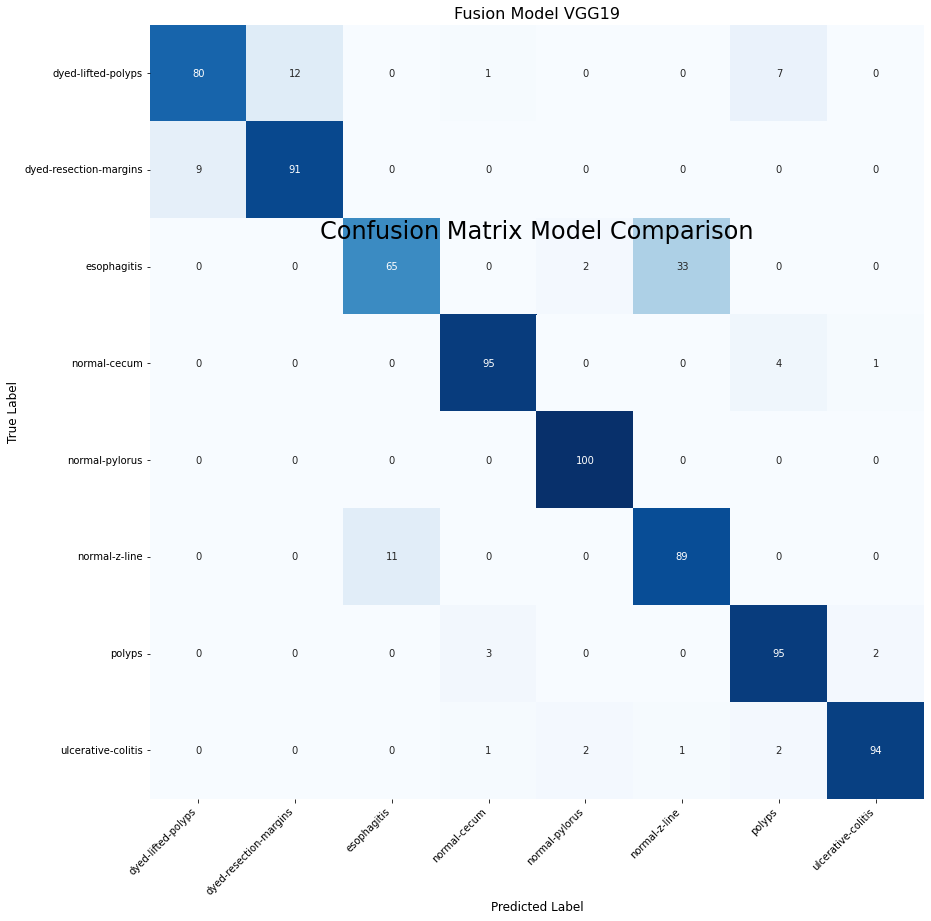

In [23]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get the names of the ten classes
class_names = test_generator.class_indices.keys()

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        xticklabels=class_names, 
        yticklabels=class_names,
        fmt='d', 
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax
    )
    ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)

fig, (ax1) = plt.subplots(1,figsize=(20, 10))
    
plot_heatmap(true_classes, VGG19_pred_classes, class_names, ax1, title="Fusion Model VGG19")    

fig.suptitle("Confusion Matrix Model Comparison", fontsize=24)
fig.tight_layout()
fig.subplots_adjust(top=1.25)
plt.show()